# CAE Anomaly Detection for Santa Cruz Islands Animl Dataset

Make sure you have the image path-labels csvs and the zip file of the data uploaded to the colab file system.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# 1. Label Cleaning & EDA
Clean up the labels and visualize the species distribution.

In [2]:
labels_df = pd.read_csv('/content/SCI_biodiversity_images_and_labels.csv')
labels_df.head()

image_path species_label
0  cropped_images/sci_biosecurity-c3ae90a3d9a22d9...           fox
1  cropped_images/sci_biosecurity-0e1bb2d5f0cfaad...       opossum
2  cropped_images/sci_biosecurity-fe89dfedaa00dc1...       opossum
3  cropped_images/sci_biosecurity-d1a8ad87dd68a02...       opossum
4  cropped_images/sci_biosecurity-8eec8e106a41356...           fox

In [3]:
print(f"Total number of images after cropping = {labels_df.shape[0]}")

Total number of images after cropping = 109903


In [4]:
labels_df['species_label'].unique()

array(['fox', 'opossum', 'rodent', 'bird', 'rat', 'skunk', 'scrub jay',
       'lizard', 'mouse', 'dog', 'vole', 'insect', 'squirrel', 'bat',
       'snake', 'bug', 'rodnet', 'liz', 'butterfly', 'frog',
       'striped skunk'], dtype=object)

In [5]:
# clean label typos
clean_labels = {'liz':'lizard', 'rodnet':'rodent', 'striped skunk': 'skunk', 'bug':'insect'}
labels_df['species_label'] = labels_df['species_label'].apply(lambda x: clean_labels.get(x, x))
labels_df['species_label'].unique()

array(['fox', 'opossum', 'rodent', 'bird', 'rat', 'skunk', 'scrub jay',
       'lizard', 'mouse', 'dog', 'vole', 'insect', 'squirrel', 'bat',
       'snake', 'butterfly', 'frog'], dtype=object)

In [6]:
# only keep the most specific species categories (for example: mouse, rat not rodent)
keep_labels = ['fox', 'opossum', 'rat', 'skunk', 'scrub jay', 'lizard', 'mouse', 'dog', 'vole', 'squirrel', 'bat',
               'snake', 'butterfly', 'frog']
filtered_labels_df = labels_df[labels_df['species_label'].isin(keep_labels)]
print(f"Total number of images after filtering top-level species = {filtered_labels_df.shape[0]}")

Total number of images after filtering top-level species = 28731


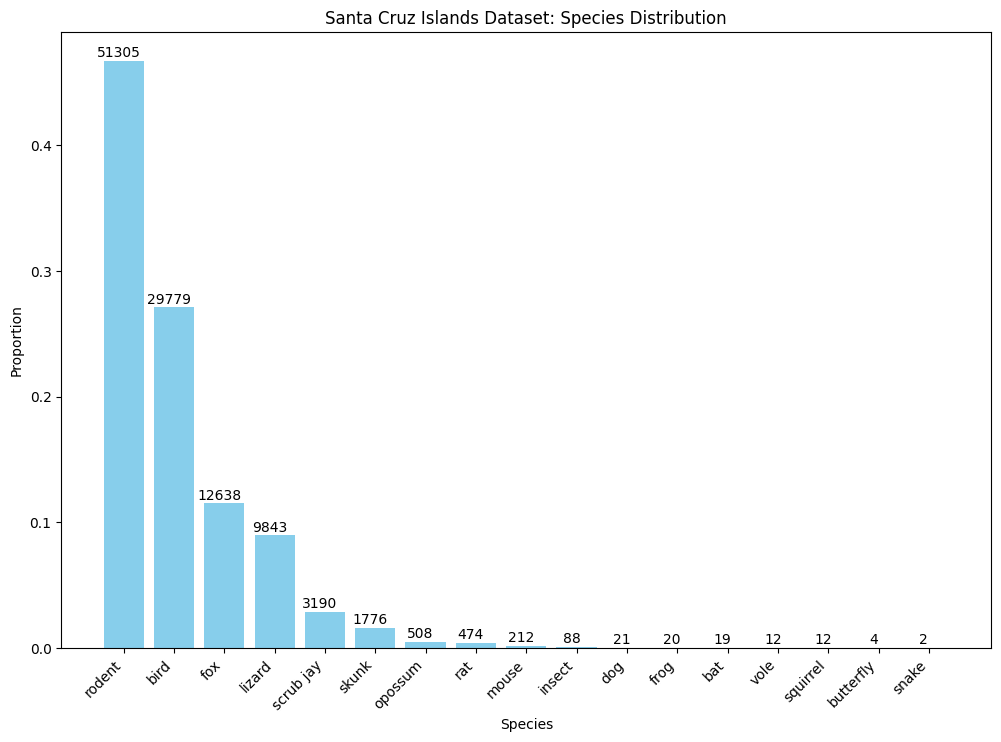

In [7]:
# visualize species distribution - before
species_proportions = labels_df['species_label'].value_counts(normalize=True).reset_index()
species_proportions.columns = ['species', 'proportion']

plt.figure(figsize=(12, 8))
bars = plt.bar(species_proportions['species'], species_proportions['proportion'], color='skyblue')

# annotating each bar with its count
for bar, count in zip(bars, labels_df['species_label'].value_counts()):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.001, f'{count}', ha='center', va='bottom')

plt.xlabel('Species')
plt.ylabel('Proportion')
plt.title('Santa Cruz Islands Dataset: Species Distribution')
plt.xticks(rotation=45, ha='right')
plt.show()

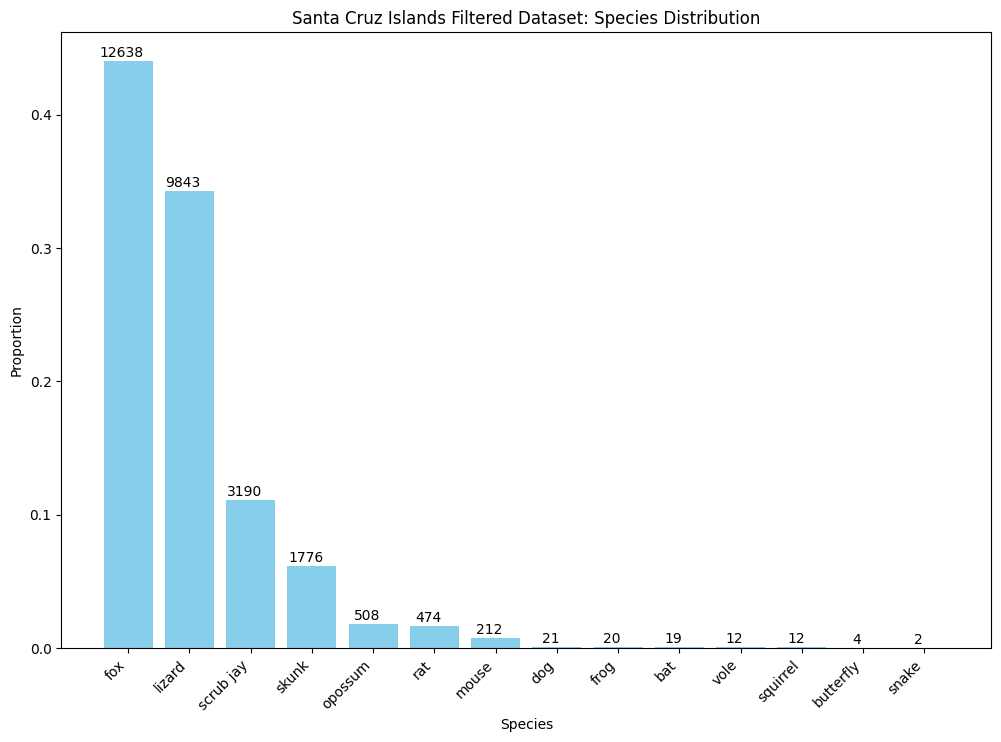

In [8]:
# visualize species distribution - after
species_proportions = filtered_labels_df['species_label'].value_counts(normalize=True).reset_index()
species_proportions.columns = ['species', 'proportion']

plt.figure(figsize=(12, 8))
bars = plt.bar(species_proportions['species'], species_proportions['proportion'], color='skyblue')

# annotating each bar with its count
for bar, count in zip(bars, filtered_labels_df['species_label'].value_counts()):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.001, f'{count}', ha='center', va='bottom')

plt.xlabel('Species')
plt.ylabel('Proportion')
plt.title('Santa Cruz Islands Filtered Dataset: Species Distribution')
plt.xticks(rotation=45, ha='right')
plt.show()

In [9]:
# based on the species proportions let's hold out the low volume species as invasive
invasive = ['dog','frog','bat','vole','squirrel','butterfly','snake']
non_invasive = ['fox','lizard','scrub jay','skunk','opossum','rat','mouse']

# 2. Anomaly detection
Train a CAE on the native species, calculate the mean and standard deviation of the validation MSE (MSE between the truth and CAE reconstructions). For each invasive species, get the reconstruction using the trained CAE, calculate the MSE. If the MSE > mean_val_mse + k*std_val_mse, then the invasive image is predicted as "invasive" (anomalous).

In [10]:
!unzip /content/sci_images.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/cropped_images/sci_biosecurity-85887b5d24624f8be8a3a499676d45a9.jpg  
  inflating: /content/cropped_images/26eaa8c4456cfb76394a273612987cc0.jpg  
  inflating: /content/cropped_images/sci_biosecurity-2e9f109b03f94b0b7e3c73a90b58c064.jpg  
  inflating: /content/cropped_images/bdaed811070bc682be4058025cb198b8.jpg  
  inflating: /content/cropped_images/sci_biosecurity-00b08da242910b42433c29f1f3667962.jpg  
  inflating: /content/cropped_images/0708b2ea63d092ce52f38b846d2293b1.jpg  
  inflating: /content/cropped_images/8fefca871a7fa5fce3073601ffac6eaa.jpg  
  inflating: /content/cropped_images/sci_biosecurity-ab7aab5ba23b4db8598e0fbf3ac4ed63.jpg  
  inflating: /content/cropped_images/sci_biosecurity-c2d932a9980b49f75d2ffae9b95bd33d.jpg  
  inflating: /content/cropped_images/sci_biosecurity-cc6ee7bd01a997e548b8dfe5ff05c393.jpg  
  inflating: /content/cropped_images/sci_biosecurity-94b36a26128a4aab431947f172471dd0.jpg  
 

In [11]:
native_images = filtered_labels_df[filtered_labels_df['species_label'].isin(non_invasive)]
invasive_images = filtered_labels_df[filtered_labels_df['species_label'].isin(invasive)]

In [12]:
# parameters
height, width, channels = 128, 128, 3
batch_size = 32
epochs = 10

# create data generators
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_dataframe(
    native_images,
    directory='/content/',
    x_col='image_path',
    y_col='image_path',
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='input',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    native_images,
    directory='/content/',
    x_col='image_path',
    y_col='image_path',
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='input',
    shuffle= False,
    subset='validation'
)

Found 22913 validated image filenames.
Found 5728 validated image filenames.


In [13]:
# Encoder
inputs = tf.keras.Input(shape=(height, width, channels), name='input_layer')

encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='conv_1')(inputs)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_1')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_1')(encoded)
encoded = tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, padding='same', name='conv_2')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_2')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_2')(encoded)
encoded = tf.keras.layers.Conv2D(16, kernel_size=3, strides=2, padding='same', name='conv_3')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_3')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_3')(encoded)

# Decoder
decoded = tf.keras.layers.Conv2DTranspose(32, 3, strides=2, padding='same', name='conv_transpose_1')(encoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_4')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_4')(decoded)
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same', name='conv_transpose_2')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_5')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_5')(decoded)
decoded = tf.keras.layers.Conv2DTranspose(channels, 3, strides=2, padding='same', name='conv_transpose_3')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_6')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_6')(decoded)

# output layer
outputs = tf.keras.layers.Conv2DTranspose(channels, 3, strides=1, padding='same', activation='sigmoid', name='conv_transpose_4')(decoded)

# create the autoencoder model
autoencoder = tf.keras.Model(inputs, outputs, name='autoencoder')
autoencoder.compile(optimizer='adam', loss='mean_squared_error')


In [14]:
# train the model
autoencoder.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/10
717/717 [==============================] - 76s 87ms/step - loss: 0.0088 - val_loss: 0.0030
Epoch 2/10
717/717 [==============================] - 64s 89ms/step - loss: 0.0038 - val_loss: 0.0026
Epoch 3/10
717/717 [==============================] - 63s 88ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 4/10
717/717 [==============================] - 63s 88ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 5/10
717/717 [==============================] - 63s 87ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 6/10
717/717 [==============================] - 63s 87ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 7/10
717/717 [==============================] - 62s 87ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 8/10
717/717 [==============================] - 64s 89ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 9/10
717/717 [==============================] - 62s 86ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 10/10
717/717 [==============================] - 60s 84ms/step - loss: 0.002

In [31]:
from PIL import Image
def view_reconstructions(df, autoencoder, target_size):
  """
  Function for randomly visualizing images and their CAE reconstructions by species.
  Note, running this function multiple times results in new images plotted.
  """
  species = df['species_label'].unique()
  for sp in species:
    sp_df = df[df['species_label']==sp]
    obs = sp_df.sample(n=1).reset_index()
    img = Image.open(obs['image_path'][0])
    img = img.resize(target_size)
    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    decoded = autoencoder.predict(img_array, verbose = 0)
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(img)
    axs[0].set_title('Original')
    axs[1].imshow(decoded[0])
    axs[1].set_title('Reconstructed')
    fig.suptitle(sp)
    plt.tight_layout()
    plt.show()

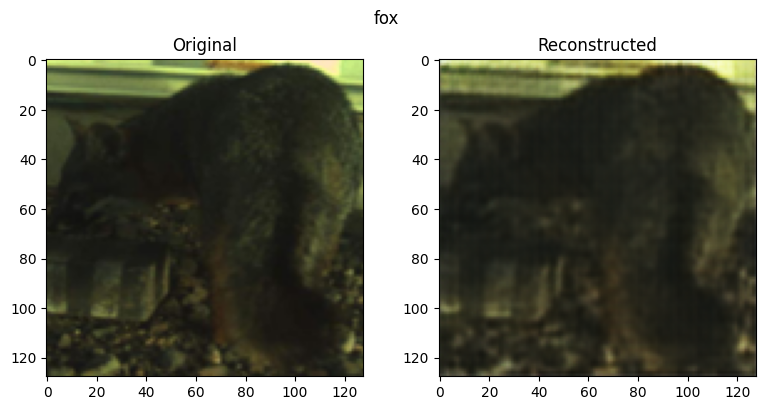

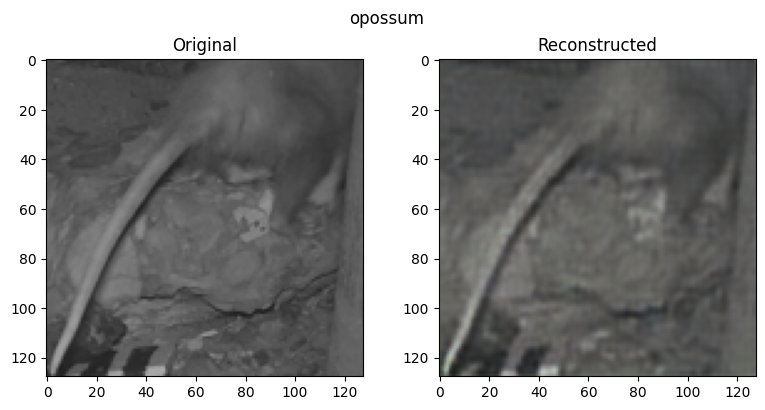

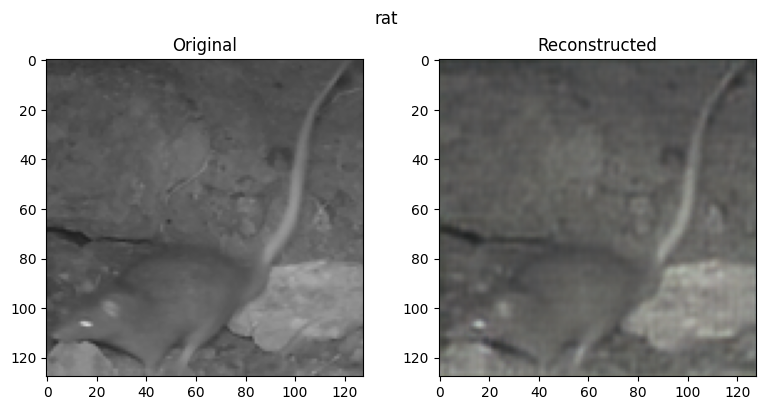

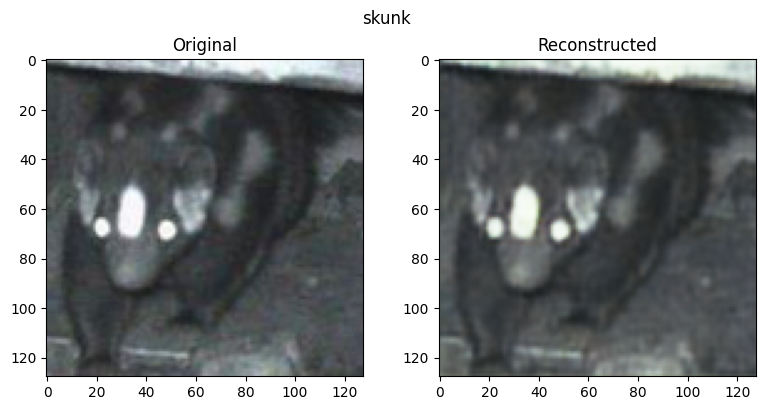

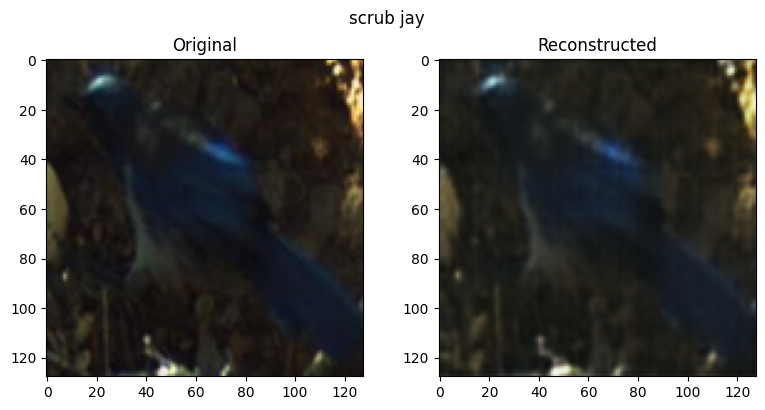

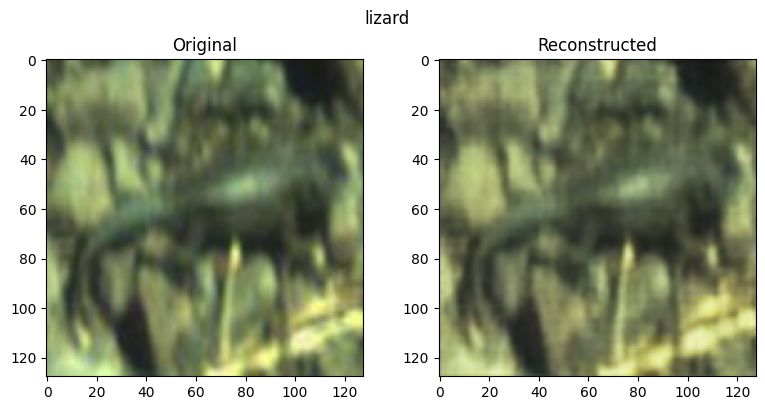

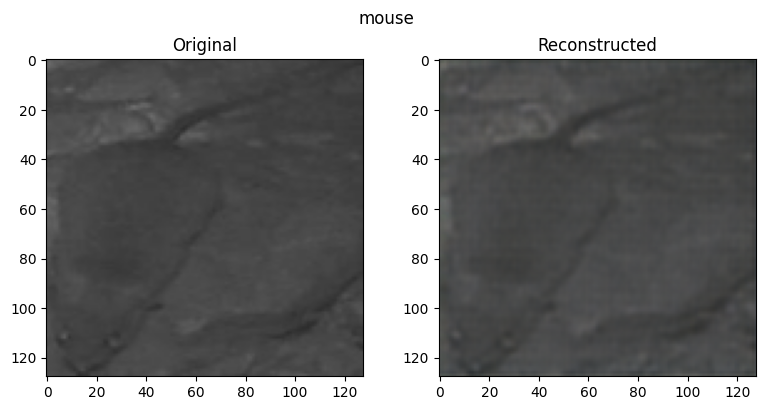

In [82]:
# validation reconstructions
view_reconstructions(native_images, autoencoder, (height, width))

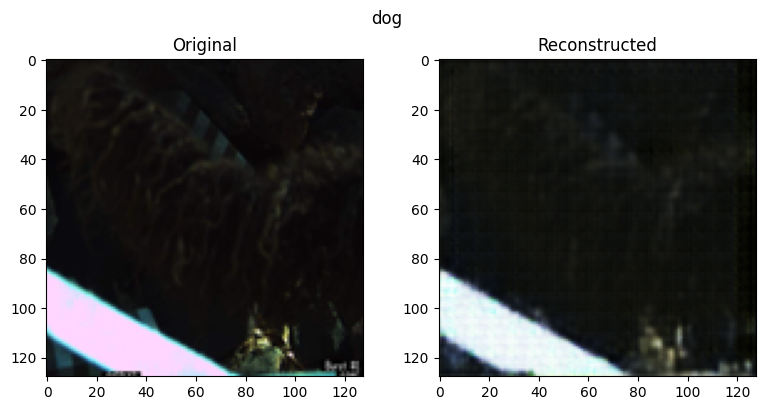

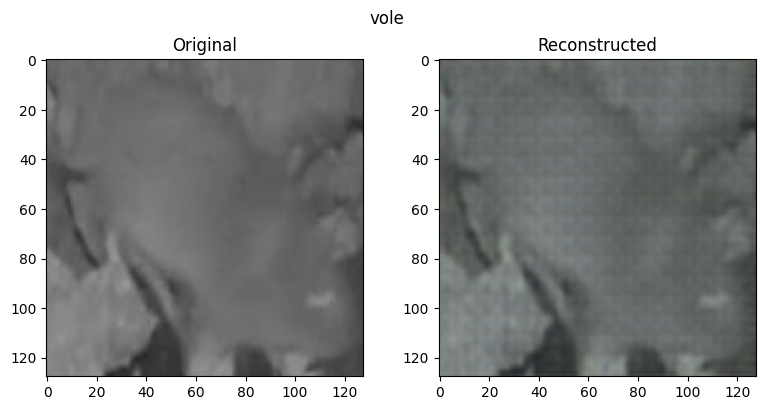

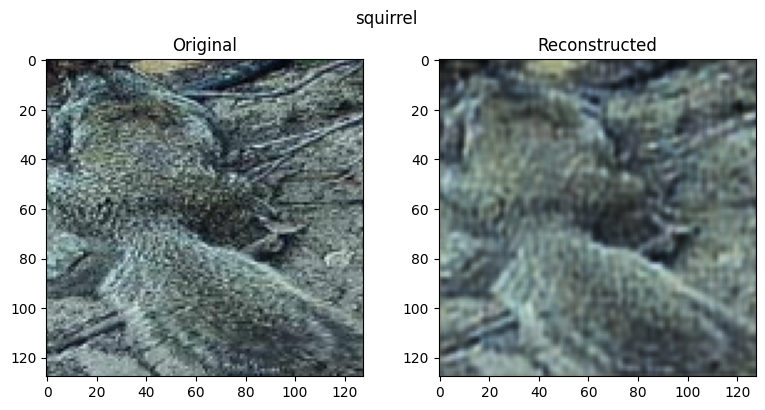

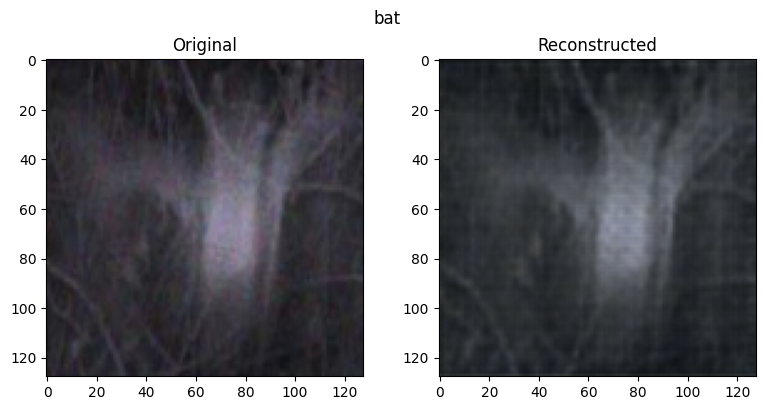

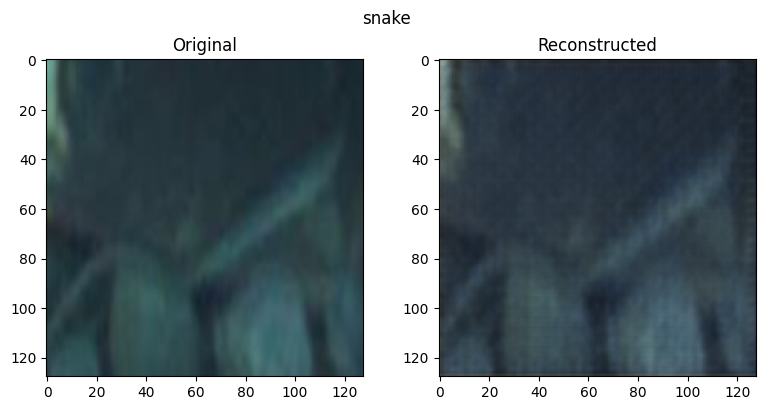

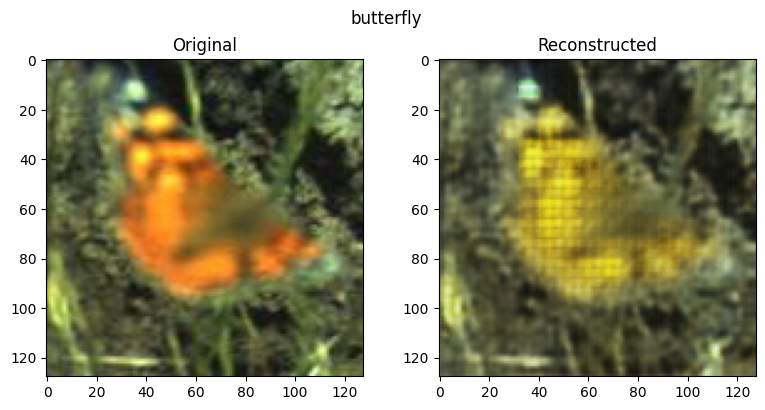

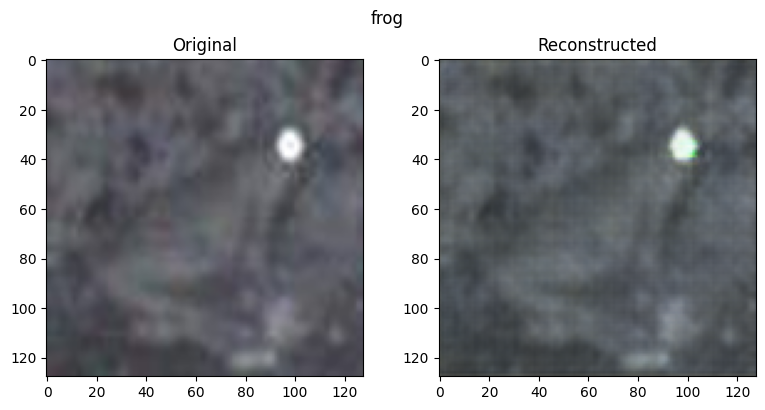

In [92]:
# invasive species reconstructions
view_reconstructions(invasive_images, autoencoder, (height, width))

In [33]:
autoencoder.save('/content/cae_native.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [34]:
# get the native species validation losses and reconstructions
val_losses = []
val_recons = []
for i in range(len(validation_generator)):
    validation_batch = validation_generator[i][0]
    reconstruction_batch = autoencoder.predict(validation_batch)
    mse_batch = np.mean(np.square(validation_batch - reconstruction_batch), axis=(1, 2, 3))
    val_losses.extend(mse_batch)
    val_recons.append(reconstruction_batch)

val_recons = np.concatenate(val_recons, axis=0)
mean_val_loss = np.mean(val_losses)
print(f"Mean Validation Loss: {mean_val_loss}")
std_val_loss = np.std(val_losses)
print(f"Standard Deviation of Validation Loss: {std_val_loss}")

1/1 [==============================] - 0s 22ms/step
Mean Validation Loss: 0.0015331784961745143
Standard Deviation of Validation Loss: 0.0023395197931677103


In [38]:
def predict_invasive(df, species_list, autoencoder, target_size):
  """
  function for reconstructing the invasive species images, returns the reconstructions
  and MSEs
  """
  sp_losses = {}
  sp_recons = {}
  for sp in species_list:
    print(f'Predicting for species {sp}...')

    # create data generator
    sp_df = df[df['species_label']==sp]
    datagen = ImageDataGenerator(rescale = 1./255)
    gen = datagen.flow_from_dataframe(
        sp_df,
        directory = '/content/',
        x_col = 'image_path',
        y_col = 'image_path',
        target_size = target_size,
        batch_size = 1,
        class_mode = 'input',
        shuffle = False
    )

    # get predictions
    losses = []
    recons = []
    for i in range(len(gen)):
        invasive_batch = gen[i][0]
        reconstruction = autoencoder.predict(invasive_batch)
        recons.append(reconstruction)
        mse_invasive = np.mean(np.square(invasive_batch - reconstruction))
        losses.append(mse_invasive)
    sp_losses[sp] = losses
    sp_recons[sp] = np.concatenate(recons, axis=0)

  return sp_losses, sp_recons


In [39]:
invasive_sp_losses, invasive_sp_recons = predict_invasive(invasive_images,invasive,autoencoder,(height,width))

Predicting for species dog...
Found 21 validated image filenames.
1/1 [==============================] - 0s 20ms/step
Predicting for species frog...
Found 20 validated image filenames.
1/1 [==============================] - 0s 17ms/step
Predicting for species bat...
Found 19 validated image filenames.
1/1 [==============================] - 0s 18ms/step
Predicting for species vole...
Found 12 validated image filenames.
1/1 [==============================] - 0s 18ms/step
Predicting for species squirrel...
Found 12 validated image filenames.
1/1 [==============================] - 0s 19ms/step
Predicting for species butterfly...
Found 4 validated image filenames.
1/1 [==============================] - 0s 18ms/step
Predicting for species snake...
Found 2 validated image filenames.
1/1 [==============================] - 0s 18ms/step


In [46]:
def calc_accuracy(sp_name, sp_losses, mean_native_loss, std_native_loss, k_list):
  """
  for each invasive species, calculate the accuracy for different thresholds
  """
  thresholds = []
  accs = []
  for k in k_list:
    threshold = mean_native_loss + k * std_native_loss
    thresholds.append(threshold)
    preds = np.where(sp_losses > threshold, 1, 0)
    accs.append(np.sum(preds==1)/len(preds))

  plt.figure(figsize=(8, 4))
  plt.plot(thresholds, accs, marker = 'o')
  title = f'{sp_name}: MSE Threshold vs Prediction Accuracy'
  plt.title(title)
  plt.xlabel("MSE Threshold = np.mean(val_mse) + k * np.std(val_mse)")
  plt.ylabel("Accuracy")
  plt.xticks(thresholds, rotation = 45)
  plt.show()

  ind = np.argmax(accs)
  best_acc = accs[ind]
  best_t = thresholds[ind]
  best_k = k_list[ind]

  return best_t, best_k, best_acc



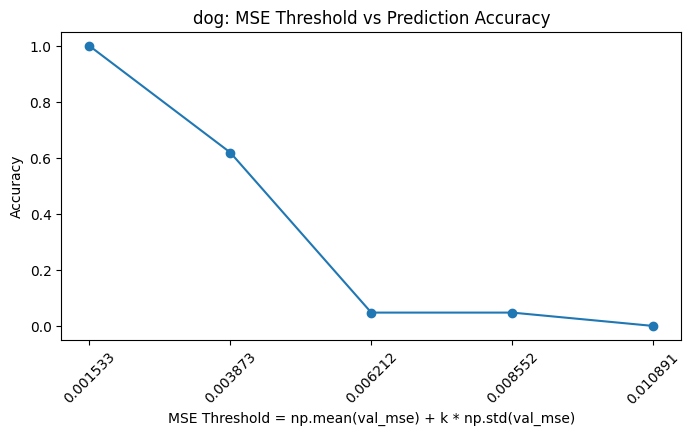

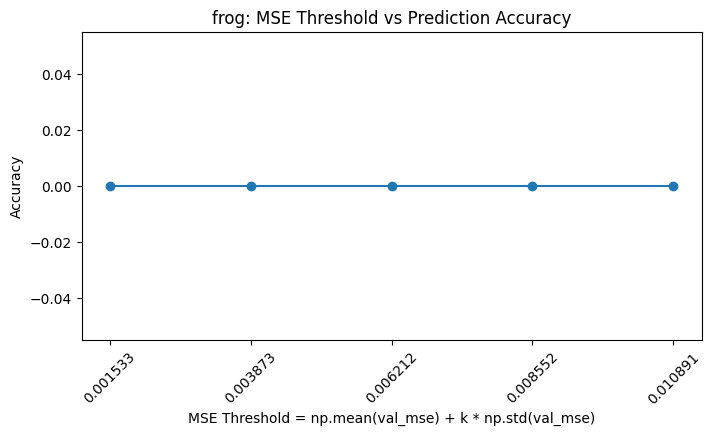

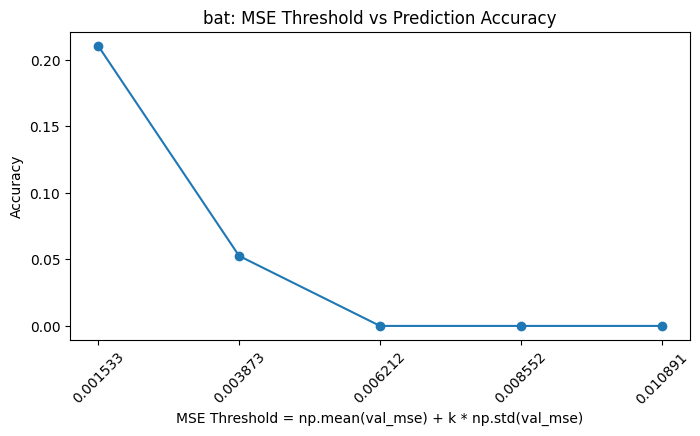

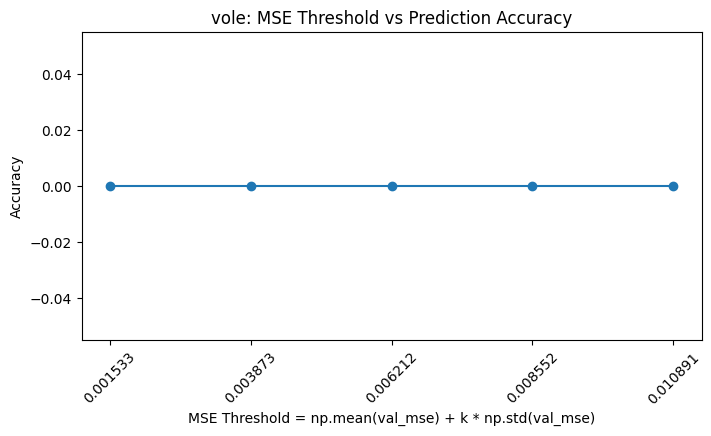

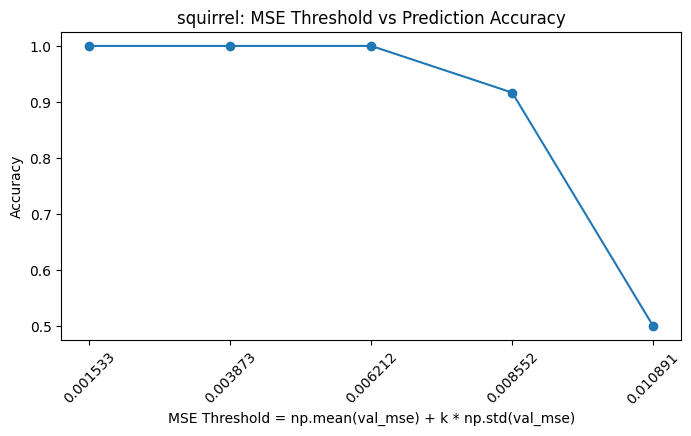

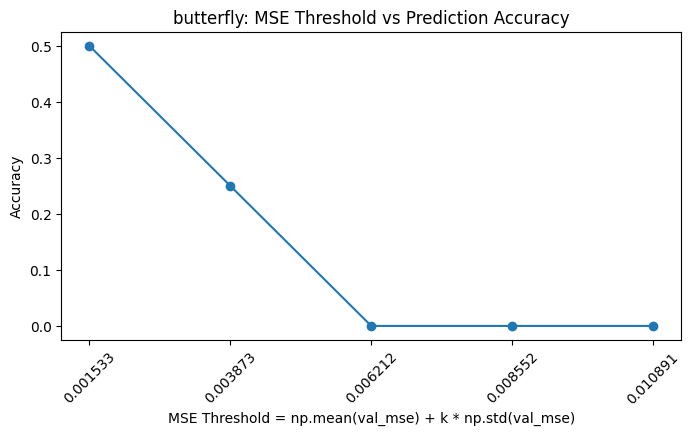

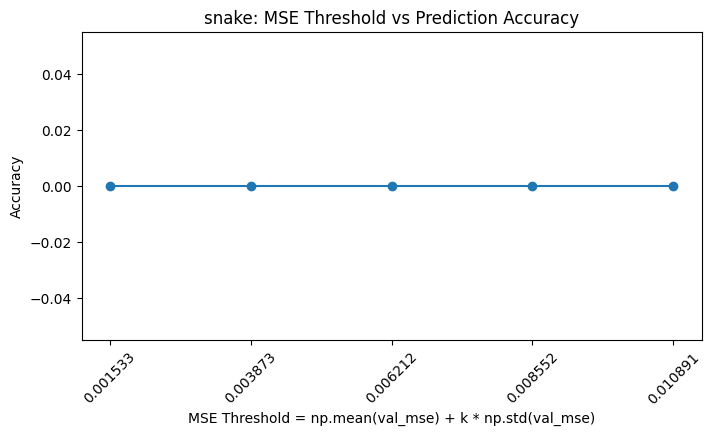

In [74]:
# more than 3 standard deviations from the mean = outlier, so using k = 3 makes the most sense,
k_list = [0,1,2,3,4]
invasive_pred_results = {}
for sp in invasive_sp_losses:
  best_t, best_k, best_acc = calc_accuracy(sp, invasive_sp_losses[sp],mean_val_loss, std_val_loss, k_list)
  invasive_pred_results[sp] = {'t':best_t, 'k':best_k, 'accuracy':best_acc}

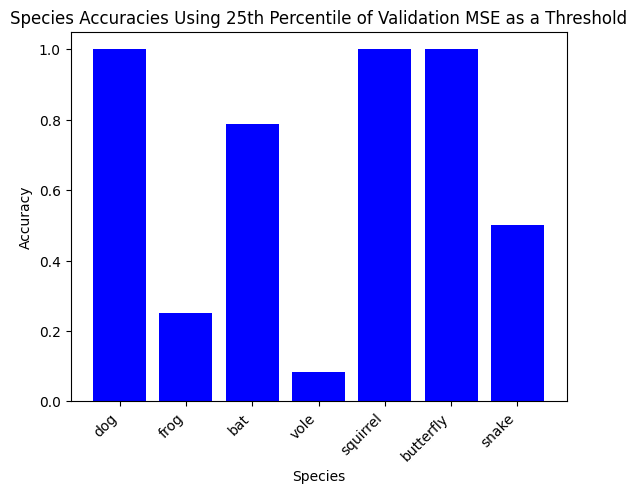

In [78]:
# Just curious, not sure if it makes sense to use 25th percentile as a threshold
val25 = np.percentile(val_losses, 25)
sps = []
accs = []
for sp in invasive_sp_losses:
  sps.append(sp)
  losses = invasive_sp_losses[sp]
  preds = np.where(losses > val25, 1, 0)
  accs.append(np.sum(preds==1)/len(preds))

plt.bar(sps, accs, color='blue')
plt.xlabel('Species')
plt.ylabel('Accuracy')
plt.title('Species Accuracies Using 25th Percentile of Validation MSE as a Threshold')
plt.xticks(rotation=45, ha='right')
plt.show()

In [69]:
def reduce_dimensionality(recon, method, p_thresh, n_components=2):
  """
  run tsne or pca on the CAE reconstructions for visualization purposes
  """
  data = recon.reshape(recon.shape[0],-1)
  if method == 'tsne':
      if data.shape[0] < p_thresh:
        p = data.shape[0]-1
      else:
        p = p_thresh
      reducer = TSNE(n_components=n_components, perplexity = p, random_state=42)
  elif method == 'pca':
      reducer = PCA(n_components=n_components, random_state=42)
      p = None
  else:
      raise ValueError("Invalid dimensionality reduction method.")
  return reducer.fit_transform(data), p

In [70]:
val_tsne, p = reduce_dimensionality(val_recons,'tsne',50) # native species val reconstruction tsne
invasive_tsne = {} # invasive species tsne
for sp in invasive:
  tsne,p = reduce_dimensionality(invasive_sp_recons[sp], 'tsne', 5)
  invasive_tsne[sp] = (tsne,p)

In [72]:
def plot_embeddings(val_emb, sp_emb, emb_type, nat_p=None):
  """
  plot embeddings (tsne or pca) of native and invasive species
  """
  for sp in sp_emb:
    emb = sp_emb[sp][0]
    p = sp_emb[sp][1]
    plt.figure(figsize=(10, 5))
    if emb_type == 'pca':
      plt.scatter(val_emb[:, 0], val_emb[:, 1], label='Native', alpha=0.5)
      plt.scatter(emb[:, 0], emb[:, 1], label=f'Invasive: {sp}', alpha=0.5)
      plt.title(f'{sp}: PCA Visualization of CAE Reconstructions')
      plt.xlabel('Principal Component 1')
      plt.ylabel('Principal Component 2')
    if emb_type == 'tsne':
      plt.scatter(val_emb[:, 0], val_emb[:, 1], label=f'Native (Perplexity = {nat_p})', alpha=0.5)
      plt.scatter(emb[:, 0], emb[:, 1], label=f'Invasive (Perplexity = {p})', alpha=0.5)
      plt.title(f'{sp}: TSNE Visualization of CAE Reconstructions')
      plt.xlabel('Dimension 1')
      plt.ylabel('Dimension 2')
    plt.legend()
    plt.show()

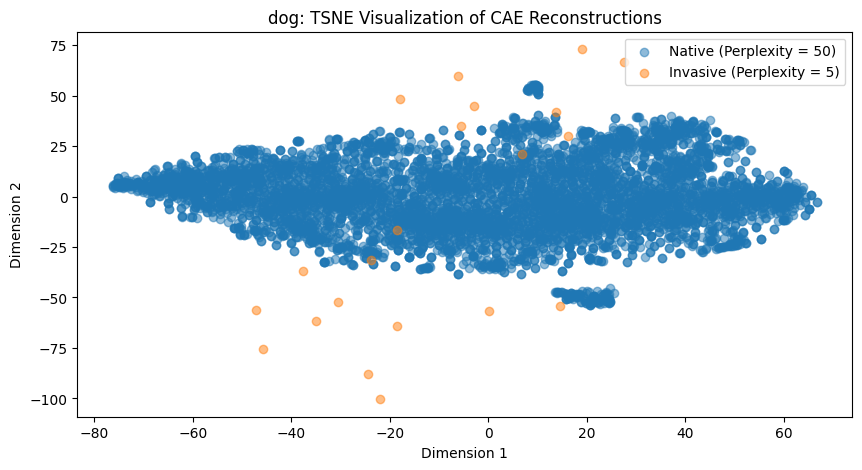

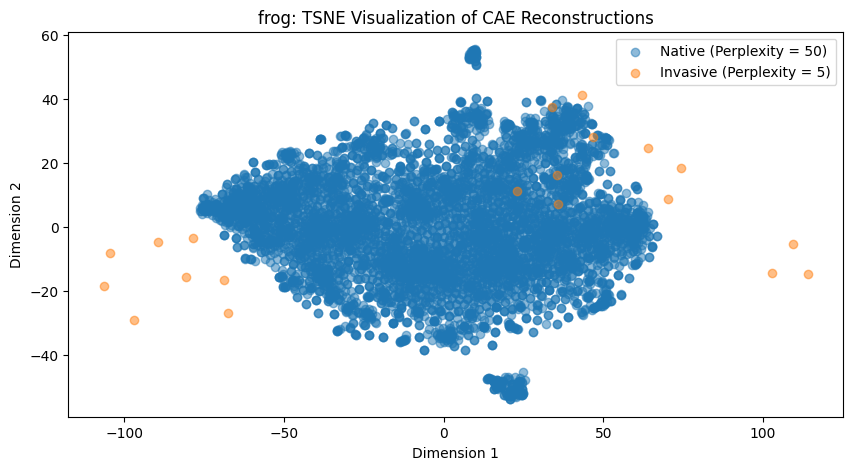

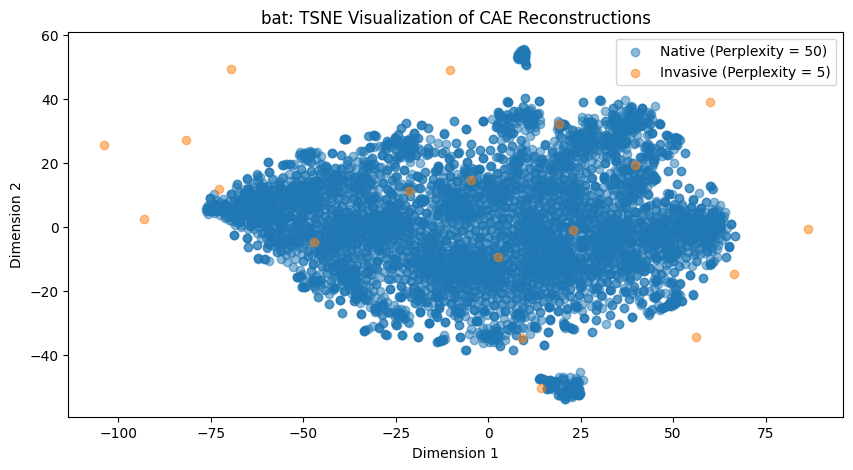

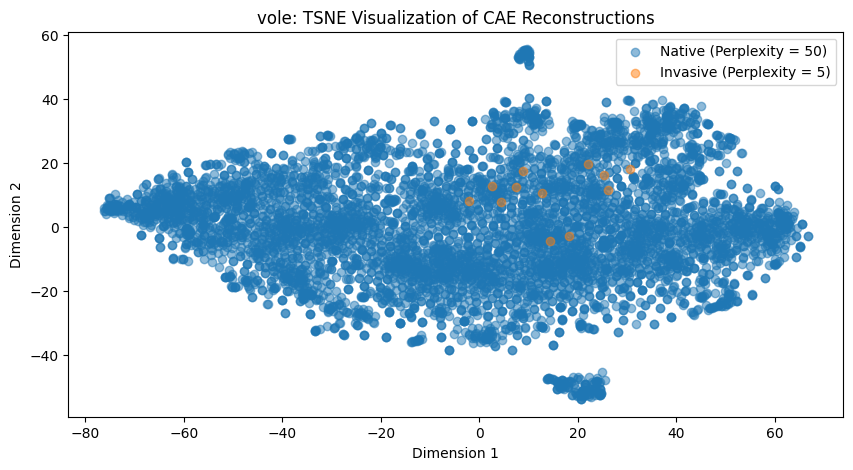

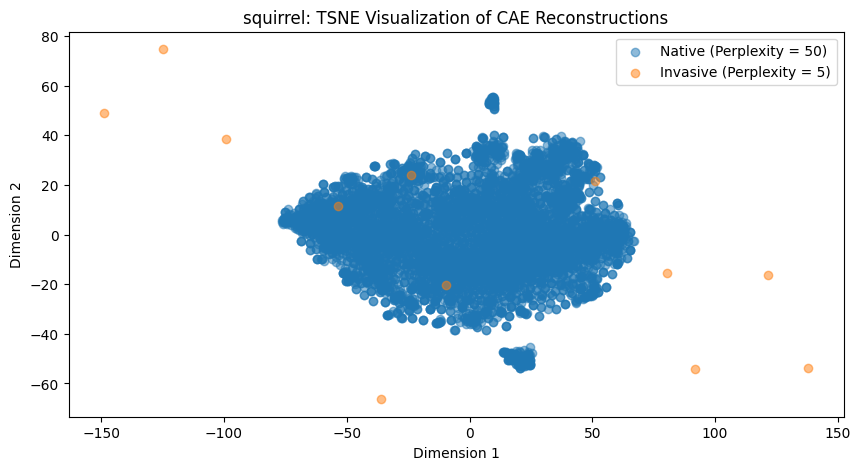

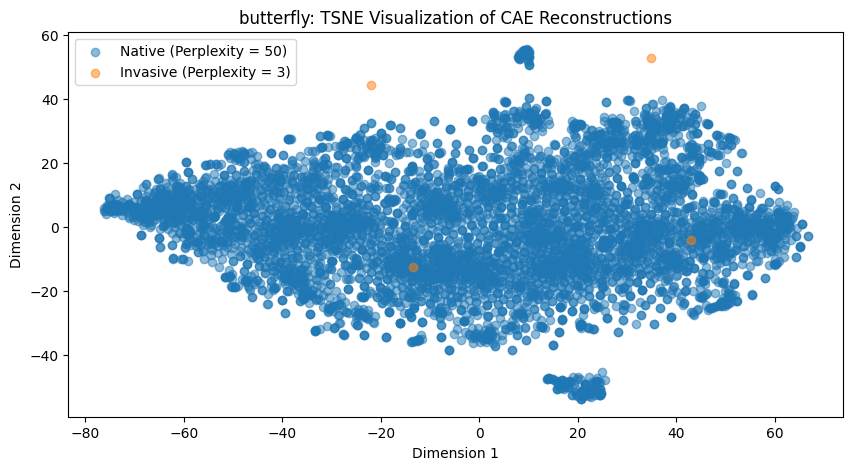

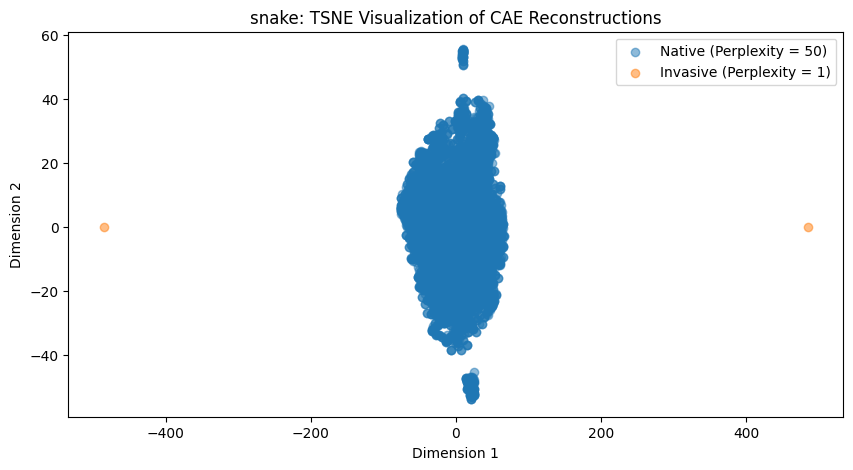

In [73]:
plot_embeddings(val_tsne, invasive_tsne, 'tsne', 50)